# Ejercicio 3 ‚Äì Predicci√≥n de series temporales con Prophet

## ¬øQu√© es Prophet?

**Prophet** es una herramienta desarrollada por Facebook para facilitar el modelado de series temporales, especialmente √∫til cuando:

- Hay **tendencias y estacionalidades** claras.
- Hay **festivos o eventos especiales**.
- Se necesita una **herramienta sencilla pero flexible** sin profundos conocimientos estad√≠sticos.

Es muy utilizado en contextos empresariales y educativos por su simplicidad y eficacia.

## ¬øC√≥mo funciona?

Prophet descompone la serie en tres componentes principales:

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

- `g(t)`: Tendencia (lineal, log√≠stica, piecewise)
- `s(t)`: Estacionalidad (diaria, semanal, anual)
- `h(t)`: Festivos o eventos especiales
- `Œµ`: Error aleatorio

---

## Flujo de trabajo

```mermaid
flowchart TD
    A[Dataset original] --> B[Renombrar columnas: ds, y]
    B --> C[Modelo Prophet b√°sico]
    C --> D[Predicci√≥n futura]
    D --> E[Visualizaci√≥n]
    E --> F[Modelo con regresores externos]
    F --> G[Comparaci√≥n de rendimiento]
```

---

## Requisitos previos
```bash
pip install prophet
```

---

## Parte 1 ‚Äì Modelo Prophet

### Paso 1: Preparar el dataset

In [41]:
from prophet import Prophet
import pandas as pd

# Cargar y preparar datos
df = pd.read_csv("data/m5_consumo_energia_train.csv", index_col=0)
df = df.set_index(pd.to_datetime(df.index))

df['dt'] = df.index

# Prophet requiere columnas: 'ds' para fecha y 'y' para valor
train_df = df.rename(columns={"dt": "ds", "Energia Consumida": "y"})

In [42]:
val_df = pd.read_csv("data/m5_consumo_energia_test.csv", index_col=0)
val_df = val_df.set_index(pd.to_datetime(val_df.index))
val_df['dt'] = val_df.index
val_df = val_df.rename(columns={"dt": "ds", "Energia Consumida": "y"})

---

### Paso 2: Crear y entrenar el modelo

In [44]:
m = Prophet()
m.fit(train_df)

22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing


---

### Paso 3: Crear futuro y predecir

In [51]:
# Predecir los pr√≥ximos 30 d√≠as
future = m.make_future_dataframe(periods=len(val_df))
forecast = m.predict(future)

---

### Paso 4: Visualizar resultado

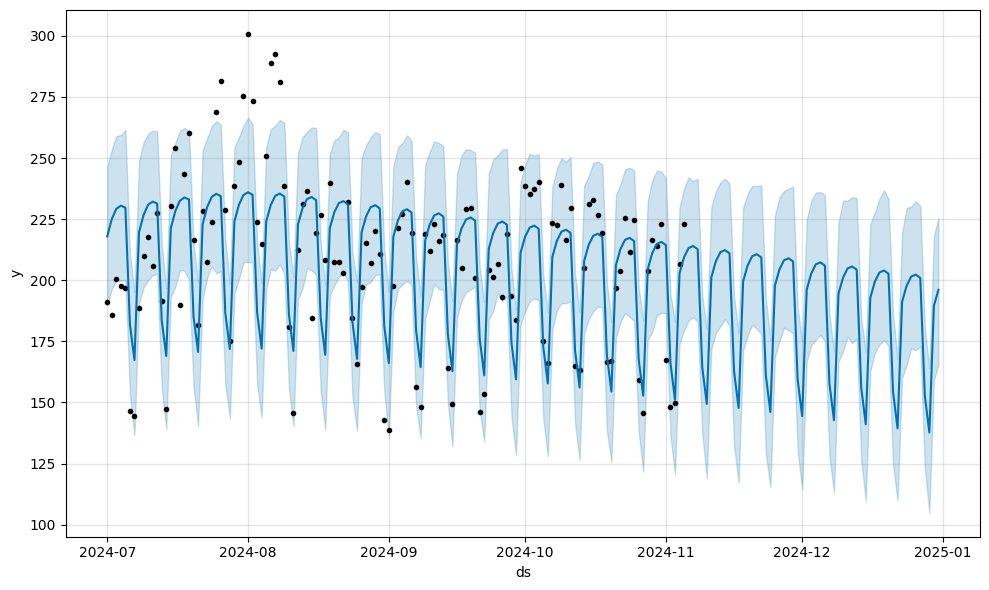

In [52]:
fig1 = m.plot(forecast)

#### Explicaci√≥n

Este es el **gr√°fico principal de predicci√≥n de Prophet**. Incluye:

- La **serie original** (l√≠nea negra o puntos).
- La **predicci√≥n** realizada por el modelo (l√≠nea azul).
- Un **intervalo de confianza del 95%** alrededor de la predicci√≥n (franja azul claro).

üîç **Interpretaci√≥n**:
- La l√≠nea azul contin√∫a donde termina la serie original y muestra el valor estimado para los d√≠as futuros.
- El √°rea azul claro indica la **incertidumbre** del modelo en cada punto futuro (m√°s ancho = m√°s incertidumbre).

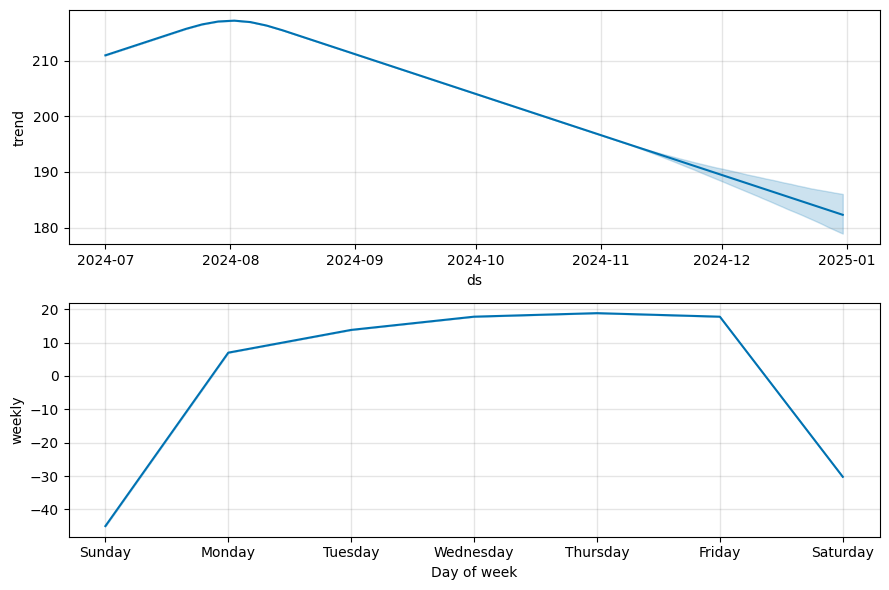

In [53]:
fig2 = m.plot_components(forecast)

### Explicaci√≥n

Este genera **una visualizaci√≥n separada de los componentes del modelo Prophet**:

1. **Tendencia (trend)**:  
   La evoluci√≥n a largo plazo del consumo.  
   Puedes ver si hay una subida, bajada, o tramos con crecimientos distintos.

2. **Estacionalidad semanal** (si existe):  
   C√≥mo var√≠a el consumo seg√∫n el d√≠a de la semana (por ejemplo, m√°s consumo entre semana que los fines de semana).

3. **Estacionalidad anual** (si hay suficientes datos):  
   Fluctuaciones repetitivas a lo largo del a√±o (m√°s relevante con >1 a√±o de datos).

4. **Otros componentes**:  
   Si has a√±adido **regresores** o **festivos**, tambi√©n se incluir√°n aqu√≠.

üîç **Interpretaci√≥n**:
- Este gr√°fico permite entender **qu√© patrones ha aprendido el modelo**, m√°s all√° de la predicci√≥n final.
- Es ideal para explicar el comportamiento estacional a otras personas no t√©cnicas.

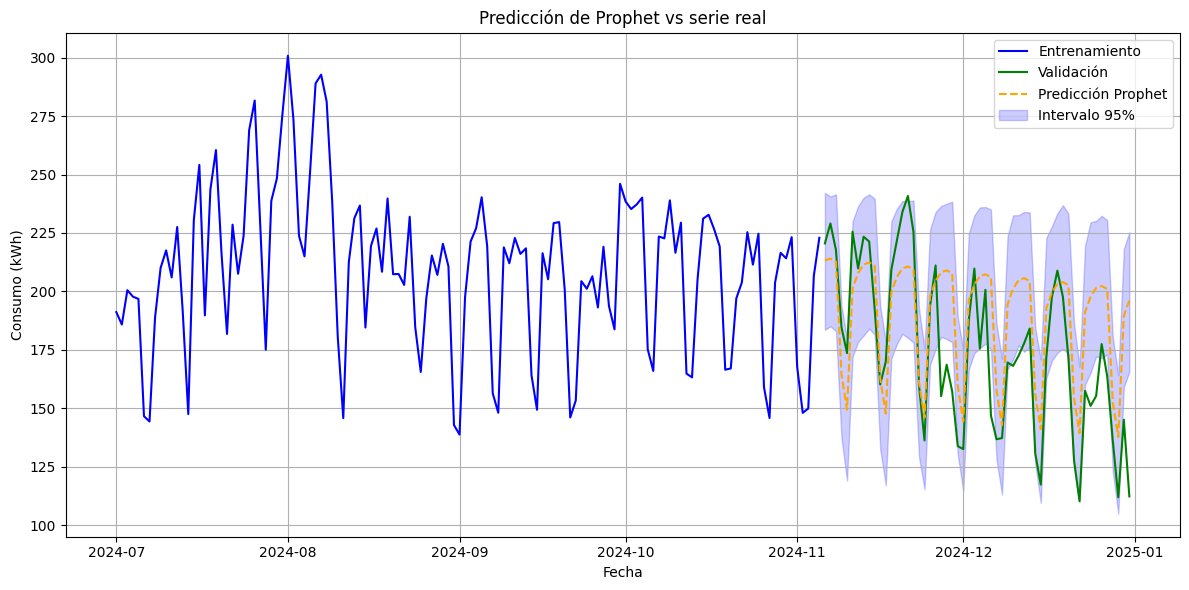

In [54]:
import matplotlib.pyplot as plt

# Tambi√©n puedes obtener el final de train como referencia
cutoff_date = train_df["ds"].max()

# Filtramos la parte futura del forecast
forecast_future = forecast[forecast["ds"] > cutoff_date]

# Graficamos todo
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(train_df["ds"], train_df["y"], label="Entrenamiento", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validaci√≥n", color="green")

# Predicci√≥n
plt.plot(forecast_future["ds"], forecast_future["yhat"], label="Predicci√≥n Prophet", color="orange", linestyle="--")

# Intervalo de confianza
plt.fill_between(forecast_future["ds"],
                 forecast_future["yhat_lower"],
                 forecast_future["yhat_upper"],
                 color="blue", alpha=0.2, label="Intervalo 95%")

# Formato
plt.title("Predicci√≥n de Prophet vs serie real")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 5: Evaluar el rendimiento del modelo

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(val_df["y"], forecast_future["yhat"])
rmse = np.sqrt(mean_squared_error(val_df["y"], forecast_future["yhat"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 22.65
RMSE: 27.93


---

## Parte 2 ‚Äì Modelado con regresores externos

Un **regresor** es una variable adicional que se incluye en el modelo para ayudar a explicar las variaciones del valor que queremos predecir.

En el contexto de consumo de energ√≠a, algunos ejemplos de regresores pueden ser:

- Temperatura (afecta al uso de aire acondicionado o calefacci√≥n)
- Humedad (relacionada con el uso de sistemas de ventilaci√≥n o agua)
- D√≠a de la semana (influye en el comportamiento de consumo en edificios)

### ¬øQu√© aporta un regresor?
**Mejora la precisi√≥n del modelo**
Al introducir una variable que est√° correlacionada con la serie temporal, el modelo puede anticiparse mejor a ciertos cambios o fluctuaciones que no se explican solo con el tiempo.

**Captura relaciones causales**
Un regresor puede reflejar una relaci√≥n de causa y efecto real. Por ejemplo, sabemos que a mayor temperatura, probablemente aumenta el consumo energ√©tico por el uso de aire acondicionado.

**Permite simular escenarios**
Si el modelo incluye regresores, podemos simular ‚Äú¬øqu√© pasar√≠a si...?‚Äù variara la temperatura o la humedad, lo que es √∫til para escenarios educativos o de planificaci√≥n.

**Reduce el error**
En muchos casos, incluir regresores mejora m√©tricas como MAE o RMSE, porque el modelo puede explicar parte del comportamiento que antes consideraba ‚Äúruido‚Äù.

### Paso 1: Visualizar correlaciones

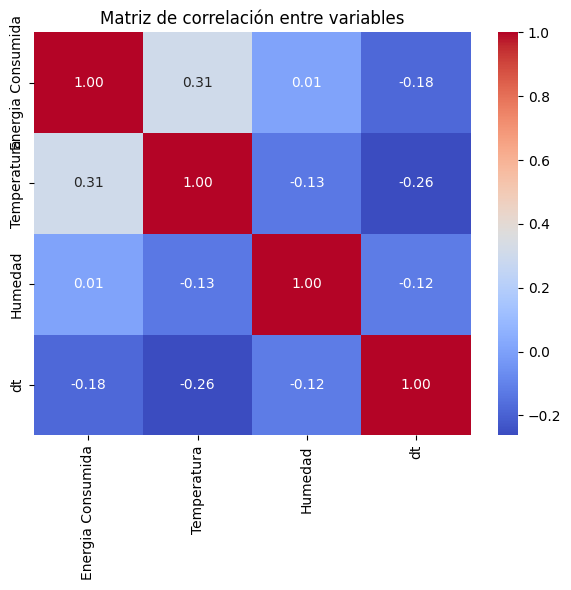

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlaci√≥n
corr = df.corr()

# Representar heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlaci√≥n entre variables")
plt.tight_layout()
plt.show()

### Paso 2: A√±adir regresores al dataframe

In [96]:
# Preparar dataset con variables externas (Temperatura y Humedad)
train_reg_df = df.reset_index().rename(columns={
    "dt": "ds",
    "Energia Consumida": "y"
})

# A√±adir regresores
train_reg_df["temperatura"] = df["Temperatura"].values
train_reg_df["humedad"] = df["Humedad"].values

---

### Paso 3: Definir modelo con regresores

In [73]:
m_reg = Prophet()
m_reg.add_regressor("temperatura")
# m_reg.add_regressor("humedad")

m_reg.fit(train_reg_df)

22:53:13 - cmdstanpy - INFO - Chain [1] start processing
22:53:13 - cmdstanpy - INFO - Chain [1] done processing


---

### Paso 3: Crear futuro con regresores

In [87]:
all_df = pd.concat([train_df, val_df], axis=0)
all_df

y  Temperatura  Humedad         ds
2024-07-01  191.15       21.710   76.765 2024-07-01
2024-07-02  185.83       21.969   73.388 2024-07-02
2024-07-03  200.53       22.129   73.098 2024-07-03
2024-07-04  197.76       22.161   75.965 2024-07-04
2024-07-05  196.79       21.929   76.122 2024-07-05
...            ...          ...      ...        ...
2024-12-27  163.73       18.800   70.509 2024-12-27
2024-12-28  136.40       19.817   63.528 2024-12-28
2024-12-29  111.97       19.278   69.048 2024-12-29
2024-12-30  145.13       18.613   64.812 2024-12-30
2024-12-31  112.31       18.397   63.389 2024-12-31

[184 rows x 4 columns]

In [ ]:
# Generar mismo n√∫mero de d√≠as futuros
future_reg = m_reg.make_future_dataframe(periods=len(val_df))
future_reg = future_reg.set_index(pd.to_datetime(future_reg['ds']))
# Aqu√≠ usamos el valor real de cada variable meteorol√≥gica
future_reg["temperatura"] = all_df['Temperatura']
# future_reg["humedad"] = list(df["Humedad"].values) + [df["Humedad"].values[-1]]*len(val_df)

In [89]:
future_reg

ds  temperatura
ds                                
2024-07-01 2024-07-01       21.710
2024-07-02 2024-07-02       21.969
2024-07-03 2024-07-03       22.129
2024-07-04 2024-07-04       22.161
2024-07-05 2024-07-05       21.929
...               ...          ...
2024-12-27 2024-12-27       18.800
2024-12-28 2024-12-28       19.817
2024-12-29 2024-12-29       19.278
2024-12-30 2024-12-30       18.613
2024-12-31 2024-12-31       18.397

[184 rows x 2 columns]

---

### Paso 4: Predecir y visualizar

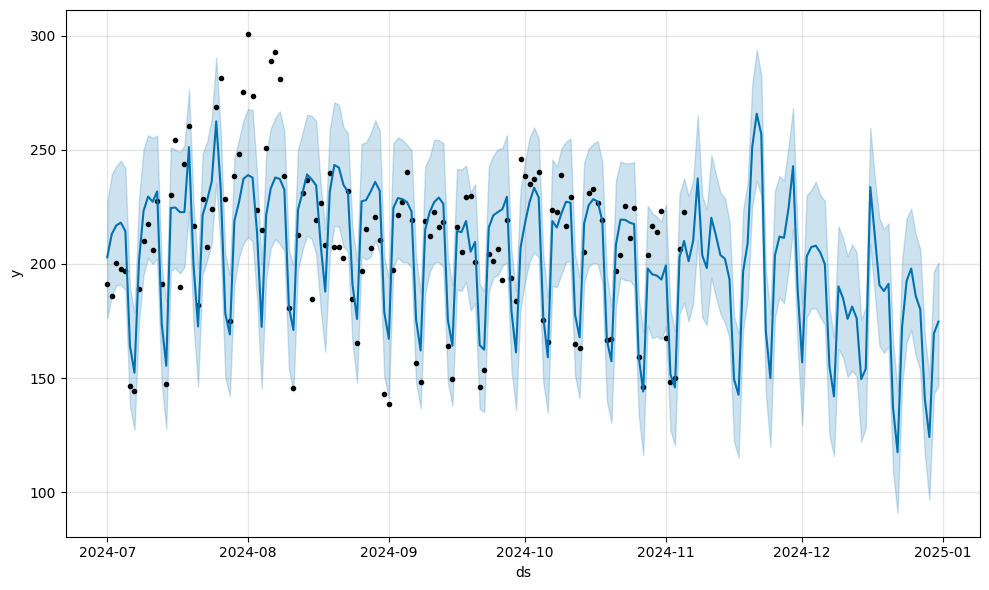

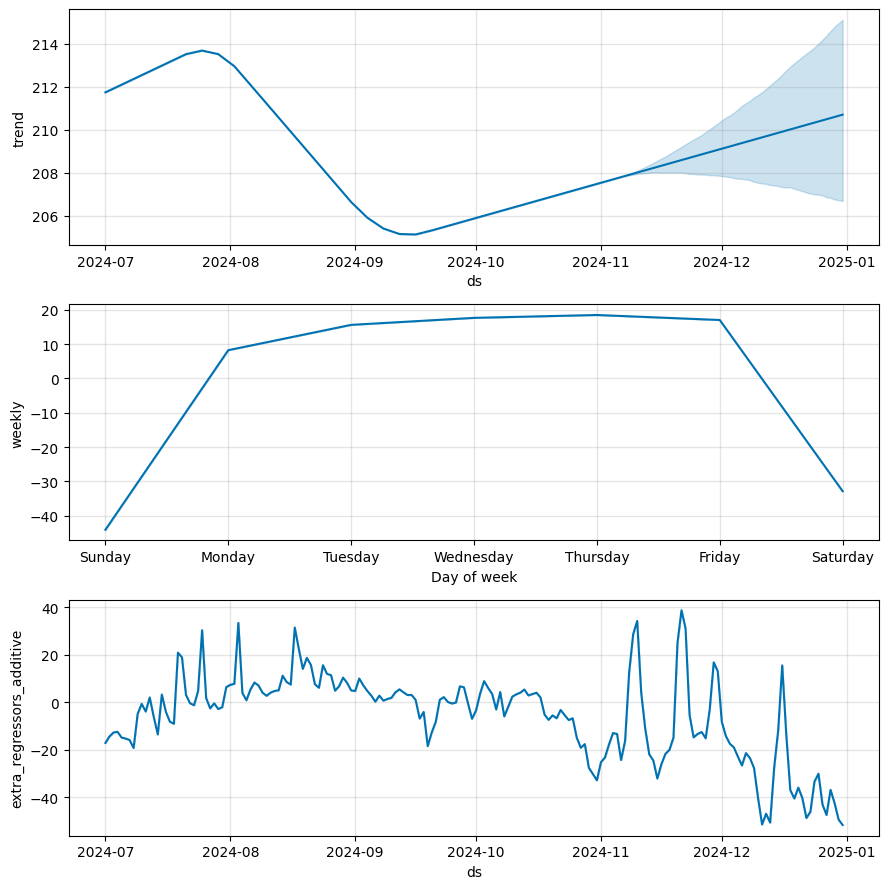

In [90]:
forecast_reg = m_reg.predict(future_reg)

# Visualizaci√≥n
fig1 = m_reg.plot(forecast_reg)
fig2 = m_reg.plot_components(forecast_reg)

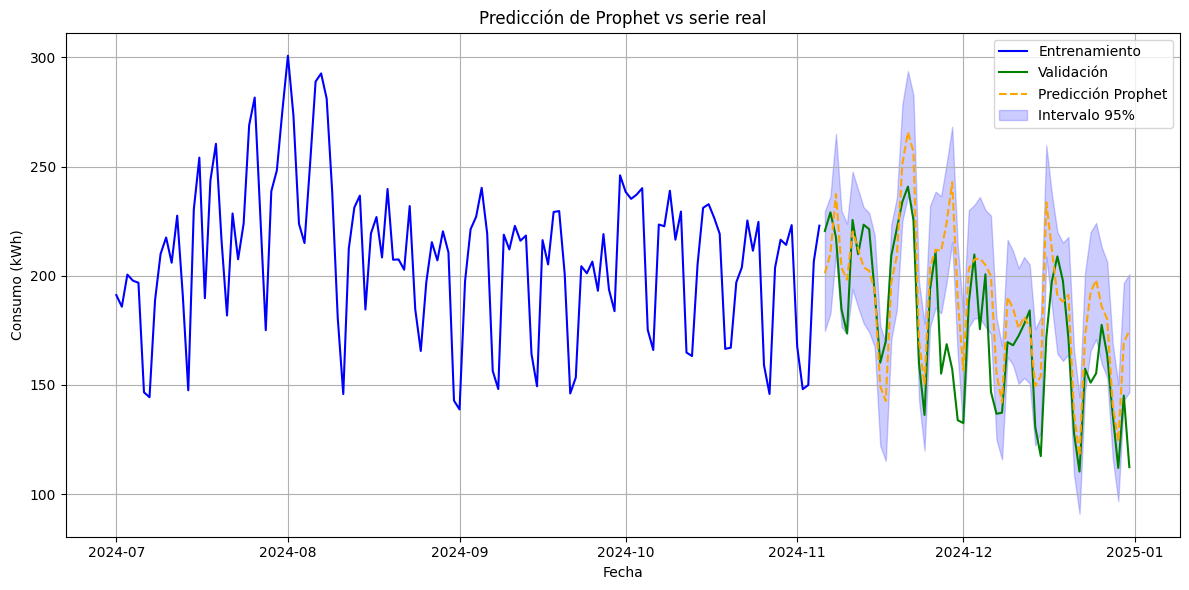

In [93]:
import matplotlib.pyplot as plt

# Tambi√©n puedes obtener el final de train como referencia
cutoff_date = train_df["ds"].max()

# Filtramos la parte futura del forecast
forecast_reg_future = forecast_reg[forecast_reg["ds"] > cutoff_date]

# Graficamos todo
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(train_df["ds"], train_df["y"], label="Entrenamiento", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validaci√≥n", color="green")

# Predicci√≥n
plt.plot(forecast_reg_future["ds"], forecast_reg_future["yhat"], label="Predicci√≥n Prophet", color="orange", linestyle="--")

# Intervalo de confianza
plt.fill_between(forecast_reg_future["ds"],
                 forecast_reg_future["yhat_lower"],
                 forecast_reg_future["yhat_upper"],
                 color="blue", alpha=0.2, label="Intervalo 95%")

# Formato
plt.title("Predicci√≥n de Prophet vs serie real")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 5: Evaluar el modelo

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(val_df["y"], forecast_reg_future["yhat"])
rmse = np.sqrt(mean_squared_error(val_df["y"], forecast_reg_future["yhat"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 21.52
RMSE: 28.15


---

## ‚úÖ Resultado esperado

- Preparar tus datos en formato adecuado para Prophet.
- Entrenar modelos con y sin regresores externos.
- Visualizar tendencias, estacionalidades y componentes.
- Comparar predicciones y detectar el efecto de variables como temperatura o humedad.